In [3]:
import torch
import torch.nn as nn
from torch import Tensor
import torchvision
import torchvision.models.resnet as resnet

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

**Task 1**

*Part 1*

In [ ]:
torch.cuda.empty_cache()

resnet_pretrained=torchvision.models.resnet152(weights='IMAGENET1K_V2', progress=True)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=32, shuffle=True,num_workers=2)
testloader_cifar10 = torch.utils.data.DataLoader( testset_cifar10, batch_size=32, shuffle=False, num_workers=2)

in_features = resnet_pretrained.fc.in_features
resnet_pretrained.fc = nn.Linear(in_features, 10)

for param in resnet_pretrained.parameters():
    param.requires_grad = False

for param in resnet_pretrained.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_pretrained.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:01<00:00, 179MB/s]
100%|██████████| 170M/170M [00:04<00:00, 34.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def training_loop(model, criterion, optimizer, trainloader, testloader, num_epochs):
  torch.cuda.empty_cache()

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_epochs):
    model.train()
    total = 0
    correct = 0
    train_loss = 0.0

    for data, labels in trainloader:
      data, labels = data.to(device), labels.to(device)

      optimizer.zero_grad()
      output = model(data)

      loss=criterion(output, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = torch.max(output.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(trainloader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * (correct / total)
    train_accuracies.append(train_accuracy)

    model.eval()
    total = 0
    correct=0
    val_loss=0.0

    with torch.no_grad():
      for data, labels in testloader:
        data, labels = data.to(device), labels.to(device)

        output = model(data)
        loss=criterion(output, labels)

        val_loss+=loss.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

      avg_val_loss = val_loss / len(testloader)
      val_losses.append(avg_val_loss)
      val_accuracy = 100 * (correct / total)
      val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

  return train_losses, train_accuracies, val_losses, val_accuracies


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_pretrained.fc.parameters(), lr=1e-3, weight_decay=1e-4)

train_losses1, train_accuracies1, val_losses1, val_accuracies1 = training_loop(resnet_pretrained, criterion, optimizer, trainloader_cifar10, testloader_cifar10, 3)

Epoch 1/3:
Train Loss: 0.6664, Train Acc: 78.77%
Val Loss: 0.4977, Val Acc: 83.64%
Epoch 2/3:
Train Loss: 0.4982, Train Acc: 83.27%
Val Loss: 0.4670, Val Acc: 84.36%
Epoch 3/3:
Train Loss: 0.4640, Train Acc: 84.40%
Val Loss: 0.4491, Val Acc: 84.98%


*Part 2*

In [ ]:

class SkipConnectionRemoved(resnet.Bottleneck):
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        return out


for i in range(3):
    old_block = resnet_pretrained.layer2[i]
    new_block = SkipConnectionRemoved(
        old_block.conv1.in_channels,
        old_block.conv3.out_channels // old_block.expansion,
        stride=old_block.stride,
        downsample=old_block.downsample,
        norm_layer=old_block.bn1.__class__,
    )
    new_block.load_state_dict(old_block.state_dict(), strict=False)
    resnet_pretrained.layer2[i] = new_block

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_pretrained = resnet_pretrained.to(device)

optimizer = torch.optim.Adam(resnet_pretrained.fc.parameters(), lr=1e-3, weight_decay=1e-4)
train_losses2, train_accuracies2, val_losses2, val_accuracies2 = training_loop(
    resnet_pretrained, criterion, optimizer, trainloader_cifar10, testloader_cifar10, 3
)

Epoch 1/3:
Train Loss: 2.2887, Train Acc: 17.49%
Val Loss: 2.1891, Val Acc: 21.39%
Epoch 2/3:
Train Loss: 2.1434, Train Acc: 21.73%
Val Loss: 2.1090, Val Acc: 23.21%
Epoch 3/3:
Train Loss: 2.1047, Train Acc: 23.15%
Val Loss: 2.0766, Val Acc: 24.43%


*Part 3*

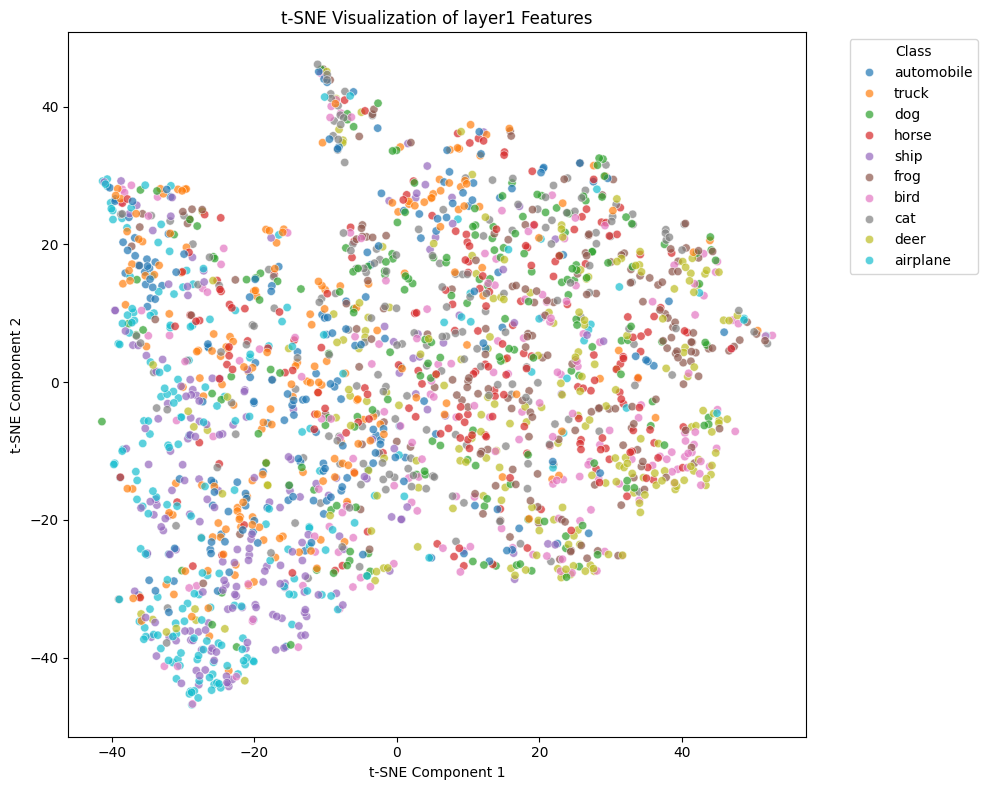

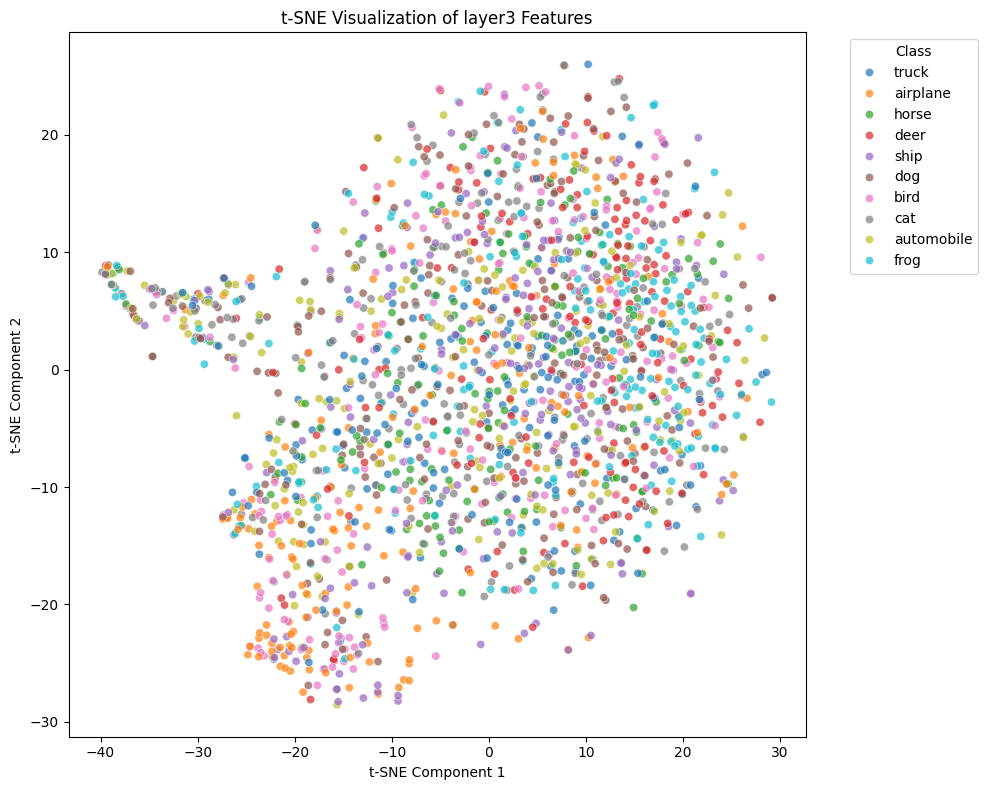

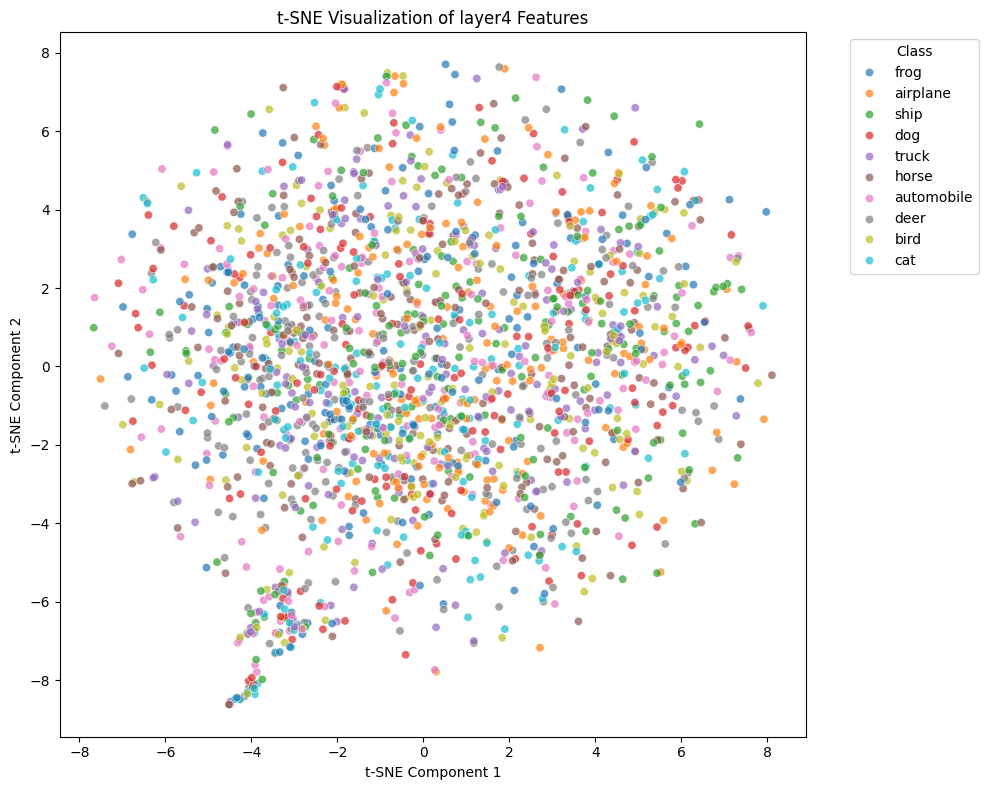

In [ ]:
features = {'layer1': [], 'layer3': [], 'layer4': []}
def collect_features(name):
    def hook(module, args, output):
        pooled_output = nn.functional.adaptive_avg_pool2d(output, (1, 1)).view(output.size(0), -1)
        features[name].append(pooled_output.detach().cpu())
    return hook

feature_hooks=[]
feature_hooks.append(resnet_pretrained.layer1.register_forward_hook(collect_features('layer1')))
feature_hooks.append(resnet_pretrained.layer3.register_forward_hook(collect_features('layer3')))
feature_hooks.append(resnet_pretrained.layer4.register_forward_hook(collect_features('layer4')))

labels_list = []
resnet_pretrained.eval()
with torch.no_grad():
    for data, labels in testloader_cifar10:
        data, labels = data.to(device), labels.to(device)
        _ = resnet_pretrained(data)
        labels_list.append(labels.cpu())

val_features = {
    'layer1': torch.cat(features['layer1'], dim=0).numpy(),
    'layer3': torch.cat(features['layer3'], dim=0).numpy(),
    'layer4': torch.cat(features['layer4'], dim=0).numpy(),
    'labels': torch.cat(labels_list, dim=0).numpy()
}

torch.save(val_features, 'val_features.pt')

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for layer_name in ['layer1', 'layer3', 'layer4']:
    features_array = val_features[layer_name]
    labels_array = val_features['labels']

    idx = random.sample(range(len(features_array)), 2000)
    features_sub = features_array[idx]
    labels_sub = labels_array[idx]
    label_names = [cifar10_classes[l] for l in labels_sub]

    features_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42).fit_transform(features_sub)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=features_embedded[:, 0],
        y=features_embedded[:, 1],
        hue=label_names,
        palette='tab10',
        legend='full',
        alpha=0.7
    )
    plt.title(f't-SNE Visualization of {layer_name} Features')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    plt.show()


*Part 4*

In [ ]:
transform_oxford = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


trainset_oxfordIIIT = torchvision.datasets.OxfordIIITPet(root="./data", split="trainval", download=True, transform=transform_oxford)
testset_oxfordIIIT = torchvision.datasets.OxfordIIITPet(root="./data", split="test", download=True, transform=transform_oxford)

trainloader_oxfordIIIT = torch.utils.data.DataLoader(trainset_oxfordIIIT, batch_size=32, shuffle=True,num_workers=2)
testloader_oxfordIIIT = torch.utils.data.DataLoader( testset_oxfordIIIT, batch_size=32, shuffle=False, num_workers=2)

pretrained_model = torchvision.models.resnet152(weights="IMAGENET1K_V2")
in_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(in_features, 37)
pretrained_model.to(device)

random_model = torchvision.models.resnet152(weights=None)
in_features = random_model.fc.in_features
random_model.fc = nn.Linear(in_features, 37)
random_model.to(device)


def freeze_blocks(model):
  for param in model.parameters():
    param.requires_grad = False

  for param in model.layer4.parameters():
    param.requires_grad = True

  for param in model.fc.parameters():
    param.requires_grad = True

def unfreeze_blocks(model):
  for param in model.parameters():
    param.requires_grad = True

freeze_blocks(pretrained_model)
freeze_blocks(random_model)

optimizer_pretrained_frozen = torch.optim.Adam(filter(lambda p: p.requires_grad, pretrained_model.parameters()), lr=1e-3)
optimizer_random_frozen = torch.optim.Adam(filter(lambda p: p.requires_grad, random_model.parameters()), lr=1e-3)

train_losses_11, train_accuracies_11, val_losses_11, val_accuracies_11 = training_loop(pretrained_model, criterion, optimizer_pretrained_frozen, trainloader_oxfordIIIT, testloader_oxfordIIIT, 3)
train_losses_12, train_accuracies_12, val_losses_12, val_accuracies_12 = training_loop(random_model, criterion, optimizer_random_frozen, trainloader_oxfordIIIT, testloader_oxfordIIIT, 3)

unfreeze_blocks(pretrained_model)
unfreeze_blocks(random_model)

optimizer_pretrained = torch.optim.Adam(pretrained_model.parameters(), lr=1e-4)
optimizer_random = torch.optim.Adam(random_model.parameters(), lr=1e-4)

train_losses_21, train_accuracies_21, val_losses_21, val_accuracies_21 = training_loop(pretrained_model, criterion, optimizer_pretrained, trainloader_oxfordIIIT, testloader_oxfordIIIT, 3)
train_losses_22, train_accuracies_22, val_losses_22, val_accuracies_22 = training_loop(random_model, criterion, optimizer_random, trainloader_oxfordIIIT, testloader_oxfordIIIT, 3)

Epoch 1/3:
Train Loss: 0.8078, Train Acc: 77.74%
Val Loss: 0.4520, Val Acc: 86.07%
Epoch 2/3:
Train Loss: 0.2081, Train Acc: 93.89%
Val Loss: 0.3839, Val Acc: 87.84%
Epoch 3/3:
Train Loss: 0.1232, Train Acc: 96.39%
Val Loss: 0.3494, Val Acc: 89.48%
Epoch 1/3:
Train Loss: 3.9882, Train Acc: 3.80%
Val Loss: 3.9924, Val Acc: 4.12%
Epoch 2/3:
Train Loss: 3.6460, Train Acc: 4.54%
Val Loss: 4.0993, Val Acc: 4.36%
Epoch 3/3:
Train Loss: 3.5721, Train Acc: 4.24%
Val Loss: 3.7270, Val Acc: 3.27%
Epoch 1/3:
Train Loss: 0.0427, Train Acc: 98.64%
Val Loss: 0.3127, Val Acc: 91.25%
Epoch 2/3:
Train Loss: 0.0306, Train Acc: 99.24%
Val Loss: 0.3318, Val Acc: 91.22%
Epoch 3/3:
Train Loss: 0.0142, Train Acc: 99.67%
Val Loss: 0.3249, Val Acc: 91.36%
Epoch 1/3:
Train Loss: 3.4905, Train Acc: 6.41%
Val Loss: 3.5542, Val Acc: 6.05%
Epoch 2/3:
Train Loss: 3.4112, Train Acc: 8.18%
Val Loss: 3.4682, Val Acc: 7.50%
Epoch 3/3:
Train Loss: 3.3501, Train Acc: 8.21%
Val Loss: 3.4183, Val Acc: 7.77%


**Task 2**

*Part 1*

In [ ]:
import torch
import requests
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor
from torchvision.transforms.functional import to_pil_image

model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True)

urls = [
    "https://images.dog.ceo/breeds/chippiparai-indian/Indian-Chippiparai.jpg",
    "https://images.dog.ceo/breeds/pomeranian/n02112018_11641.jpg",
    "https://images.dog.ceo/breeds/beagle/n02088364_12972.jpg"
]

pil_images = [Image.open(requests.get(url, stream=True).raw).convert("RGB") for url in urls]

inputs = processor(images=pil_images, return_tensors="pt")

with torch.no_grad():
    vit_outputs = model(**inputs)
    logits = vit_outputs.logits
    predictions = logits.argmax(-1).tolist()

id2label = model.config.id2label
for i, pred in enumerate(predictions):
    print(f"Image {i+1}: ViT prediction = {id2label[pred]}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Image 1: ViT prediction = Ibizan hound, Ibizan Podenco
Image 2: ViT prediction = Pomeranian
Image 3: ViT prediction = beagle


*Part 2*

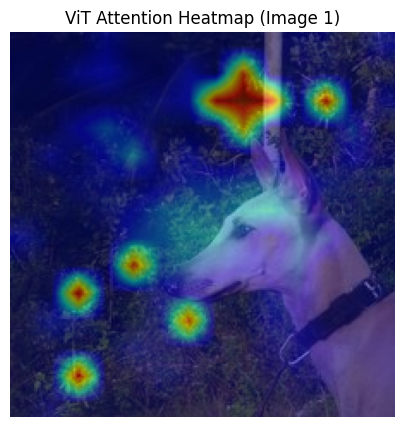

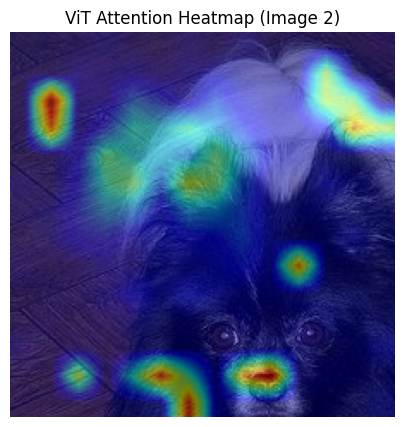

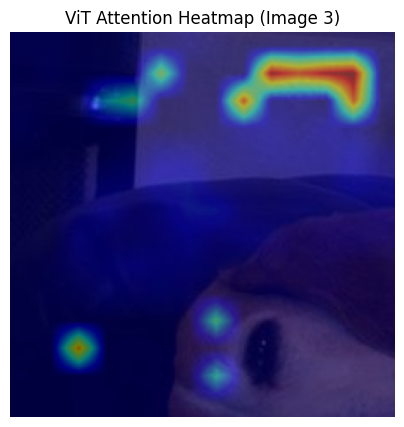

In [ ]:
import torch.nn.functional as F

attentions = vit_outputs.attentions

last_attn = attentions[-1]
attn_matrix = last_attn.mean(dim=1)

cls_attn = attn_matrix[:, 0, 1:]
cls_attn_map = cls_attn.reshape(-1, 14, 14)

cls_attn_map_norm = (cls_attn_map - cls_attn_map.min()) / (cls_attn_map.max() - cls_attn_map.min())
cls_attn_map_upsampled = F.interpolate(
    cls_attn_map_norm.unsqueeze(1), size=(224, 224), mode="bilinear"
)


for i in range(3):
    img = pil_images[i]
    attn_map = cls_attn_map_upsampled[i,0].cpu().numpy()

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.imshow(attn_map, cmap='jet', alpha=0.5)
    plt.axis("off")
    plt.title(f"ViT Attention Heatmap (Image {i+1})")
    plt.show()

*Part 4*

In [ ]:
import torch
import numpy as np
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

def denorm_to_pil(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img_tensor.cpu() * std + mean
    img = img.clamp(0,1)
    return to_pil_image(img)

def mask_patches_pil(pil_image, mask_type="random", mask_ratio=0.3, patch_size=16, center_block=2):
    if mask_type is None:
        return pil_image
    img = np.array(pil_image).copy()
    H, W = img.shape[:2]
    grid_h = H // patch_size
    grid_w = W // patch_size
    num_patches = grid_h * grid_w

    if mask_type == "random":
        mask_count = int(num_patches * mask_ratio)
        patch_indices = np.random.choice(num_patches, mask_count, replace=False)
    elif mask_type == "center":
        center_r = grid_h // 2
        center_c = grid_w // 2
        patch_indices = []
        half = center_block
        for r in range(center_r - half, center_r + half):
            for c in range(center_c - half, center_c + half):
                if 0 <= r < grid_h and 0 <= c < grid_w:
                    patch_indices.append(r * grid_w + c)

    for idx in patch_indices:
        row = idx // grid_w
        col = idx % grid_w
        y0 = row * patch_size
        x0 = col * patch_size
        img[y0:y0+patch_size, x0:x0+patch_size, :] = 0

    return Image.fromarray(img)

def inputs_to_device(inputs, device):
    return {k: v.to(device) for k,v in inputs.items()}

def evaluate_masking_simple(model, processor, dataloader, device, mask_types=("random","center"), mask_ratio=0.3, num_images=200, patch_size=16, center_block=2):
    model.eval()
    counts = {m: 0 for m in mask_types}
    total = 0
    saved_example = None

    it = iter(dataloader)
    while total < num_images:
        try:
            images, labels = next(it)
        except StopIteration:
            break
        for i in range(images.size(0)):
            if total >= num_images:
                break
            t = images[i]
            pil = denorm_to_pil(t)

            inputs_un = processor(images=pil, return_tensors="pt")
            inputs_un = inputs_to_device(inputs_un, device)
            with torch.no_grad():
                out_un = model(**inputs_un)
                top1_un = int(out_un.logits.argmax(dim=-1).item())

            for m in mask_types:
                if m == "random":
                    masked_pil = mask_patches_pil(pil, mask_type="random", mask_ratio=mask_ratio, patch_size=patch_size, center_block=center_block)
                else:
                    masked_pil = mask_patches_pil(pil, mask_type="center", mask_ratio=mask_ratio, patch_size=patch_size, center_block=center_block)

                inputs_m = processor(images=masked_pil, return_tensors="pt")
                inputs_m = inputs_to_device(inputs_m, device)
                with torch.no_grad():
                    out_m = model(**inputs_m)
                    top1_m = int(out_m.logits.argmax(dim=-1).item())

                if top1_m == top1_un:
                    counts[m] += 1

                if saved_example is None:
                    saved_example = {
                        "orig_pil": pil,
                        "masked_random": mask_patches_pil(pil, mask_type="random", mask_ratio=mask_ratio, patch_size=patch_size),
                        "masked_center": mask_patches_pil(pil, mask_type="center", mask_ratio=mask_ratio, patch_size=patch_size, center_block=center_block),
                        "unmasked_top1": top1_un,
                        "random_top1": top1_m if m=="random" else None,
                        "center_top1": top1_m if m=="center" else None
                    }

            total += 1

    accuracies = {m: (counts[m] / total * 100.0) for m in mask_types}
    return accuracies, saved_example

mask_ratio = 0.3
center_block = 2
num_images = 200

accuracies, example = evaluate_masking_simple(
    model, processor, testloader_cifar10, device,
    mask_types=("random","center"),
    mask_ratio=mask_ratio,
    num_images=num_images,
    patch_size=16,
    center_block=center_block
)

print(f"Agreement accuracy (random mask {mask_ratio*100:.0f}% patches): {accuracies['random']:.2f}%")
print(f"Agreement accuracy (center mask {center_block*2}x{center_block*2} patches): {accuracies['center']:.2f}%")

Agreement accuracy (random mask 30% patches): 58.50%
Agreement accuracy (center mask 4x4 patches): 68.00%


*Part 5*

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torchvision.transforms.functional import to_pil_image

from transformers import ViTModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ViTFeatureExtractor(nn.Module):
    def __init__(self, vit_model, use_cls=True):
        super().__init__()
        self.vit = vit_model
        self.use_cls = use_cls
        self.vit.eval()
        for p in self.vit.parameters():
            p.requires_grad = False

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values, output_hidden_states=True, return_dict=True)
        last_hidden = outputs.last_hidden_state
        if self.use_cls:
            feats = last_hidden[:, 0]
        else:
            feats = last_hidden[:, 1:].mean(dim=1)
        return feats

class LinearProbe(nn.Module):
    def __init__(self, feat_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

def train_probe(extractor, probe, dataloader, num_epochs=5, lr=1e-3):
    extractor.eval()
    probe.train()
    optimizer = optim.Adam(probe.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            pil_images = [denorm_to_pil(img) for img in images]

            pixel_values = processor(images=pil_images, return_tensors="pt").pixel_values.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                feats = extractor(pixel_values)

            logits = probe(feats)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1} | Loss: {total_loss/len(dataloader):.4f}")

def eval_probe(extractor, probe, dataloader):
    extractor.eval()
    probe.eval()
    preds, trues = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            pil_images = [denorm_to_pil(img) for img in images]
            pixel_values = processor(images=pil_images, return_tensors="pt").pixel_values.to(device)
            feats = extractor(pixel_values)
            logits = probe(feats)
            pred = logits.argmax(dim=-1).cpu()
            preds.extend(pred.tolist())
            trues.extend(labels.tolist())
    return accuracy_score(trues, preds)

num_classes = 10
hidden_dim = model.config.hidden_size

vit_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)

extractor_cls = ViTFeatureExtractor(vit_encoder, use_cls=True).to(device)
probe_cls = LinearProbe(hidden_dim, num_classes).to(device)
train_probe(extractor_cls, probe_cls, trainloader_cifar10, num_epochs=3)
acc_cls = eval_probe(extractor_cls, probe_cls, testloader_cifar10)
print(f"Linear probe (CLS token): {acc_cls*100:.2f}%")

extractor_mean = ViTFeatureExtractor(vit_encoder, use_cls=False).to(device)
probe_mean = LinearProbe(hidden_dim, num_classes).to(device)
train_probe(extractor_mean, probe_mean, trainloader_cifar10, num_epochs=5)
acc_mean = eval_probe(extractor_mean, probe_mean, testloader_cifar10)
print(f"Linear probe (mean patch tokens): {acc_mean*100:.2f}%")


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████| 1563/1563 [12:07<00:00,  2.15it/s]


Epoch 1 | Loss: 0.1290


Epoch 2/3: 100%|██████████| 1563/1563 [12:06<00:00,  2.15it/s]


Epoch 2 | Loss: 0.0820


Epoch 3/3: 100%|██████████| 1563/1563 [12:05<00:00,  2.15it/s]

Epoch 3 | Loss: 0.0701


Linear probe (CLS token): 96.73%


Epoch 1/5:  15%|█▌        | 239/1563 [01:51<10:04,  2.19it/s]

**Task 3**

*Part 1.1*

In [7]:
def load_dataset(name):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize(mean=0.5, std=0.5)
    ])

    if(name=='MNIST'):
        trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

        testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

    elif(name=='FashionMNIST'):
        trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

        testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

    return trainloader, testloader

MNIST_trainloader, MNIST_testloader = load_dataset('MNIST');

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.63MB/s]


*Part 1.2*

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        self.z_dim=z_dim
        super(Generator, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        x=self.model(x)
        x=x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model=nn.Sequential(
            nn.Flatten(),

            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x=self.model(x)
        return x


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim=100
G = Generator(z_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=256, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

*Part 1.3*

In [ ]:
GAN_criterion = nn.BCELoss()

G_optimizer = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

*Part 1.4*

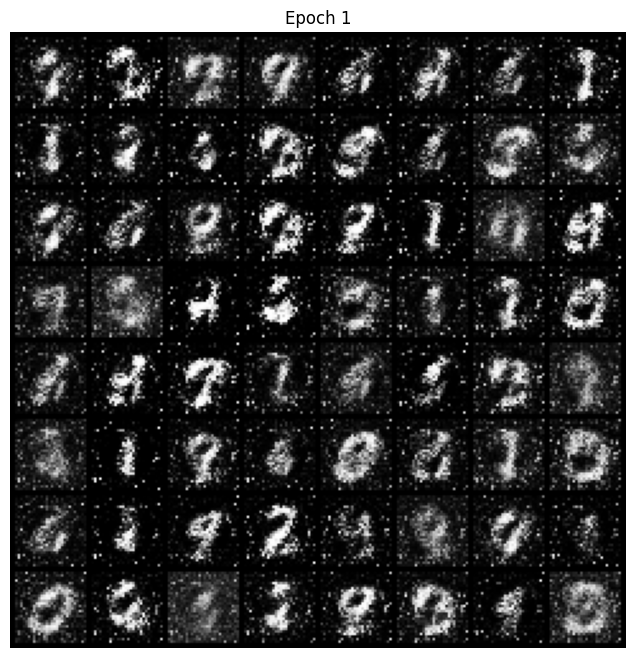

Epoch [5/40] | D Loss: 1.1509 | G Loss: 1.2913
Epoch [10/40] | D Loss: 1.2372 | G Loss: 1.0746


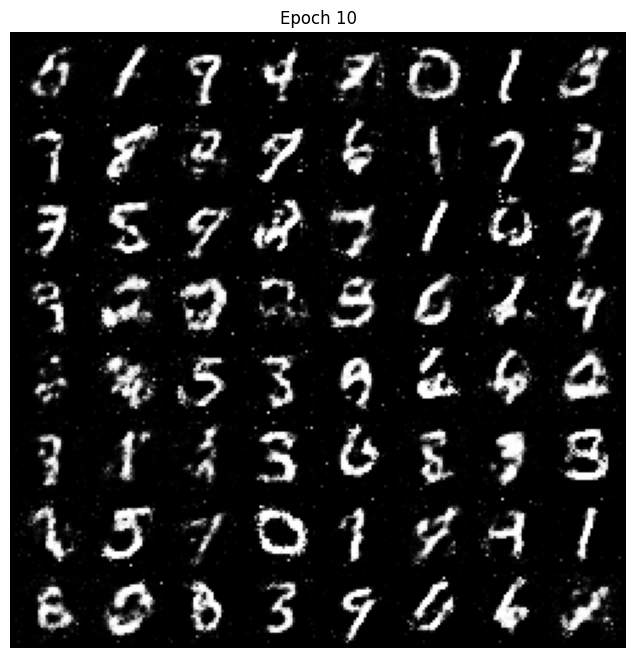

Epoch [15/40] | D Loss: 1.2769 | G Loss: 1.0056
Epoch [20/40] | D Loss: 1.2933 | G Loss: 0.9727


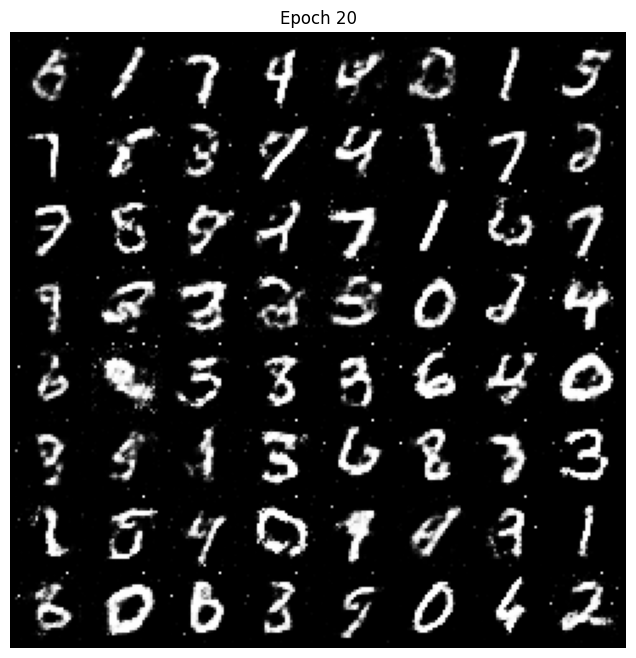

Epoch [25/40] | D Loss: 1.3001 | G Loss: 0.9576
Epoch [30/40] | D Loss: 1.3099 | G Loss: 0.9426


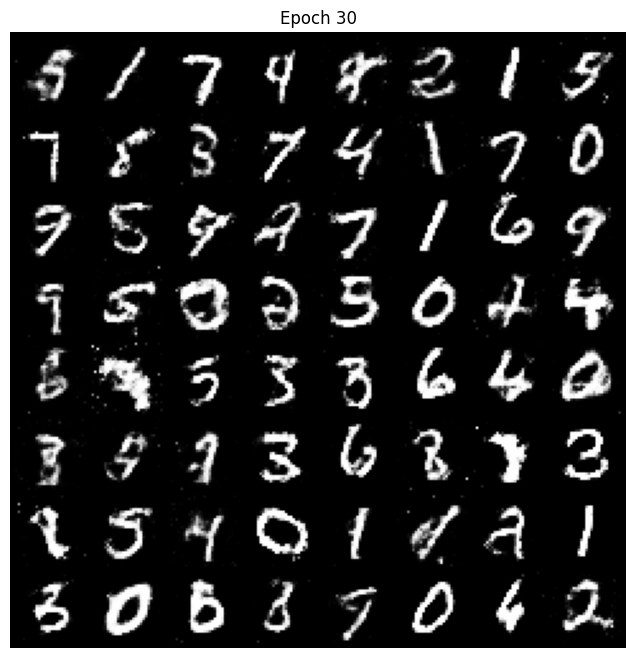

Epoch [35/40] | D Loss: 1.3085 | G Loss: 0.9422
Epoch [40/40] | D Loss: 1.3096 | G Loss: 0.9380


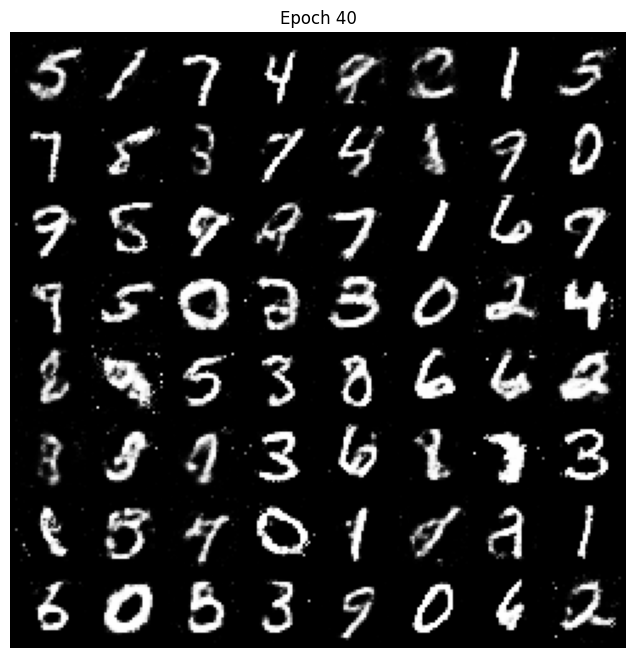

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs=40
D_losses=[]
G_losses=[]

z_fixed = torch.randn(64, z_dim, device=device)

for epoch in range(epochs):
    D_loss_total=0.0
    G_loss_total=0.0

    for real_images, _ in MNIST_trainloader:
        real_images = real_images.to(device)
        smoothed_real_labels = torch.full((real_images.size(0), 1), 0.9, device=device)

        z_d=torch.randn(real_images.size(0), z_dim, device=device)

        fake_images_d=G(z_d)
        fake_labels=torch.zeros(real_images.size(0), 1, device=device)

        D.train()
        D_optimizer.zero_grad()

        real_noise=torch.randn_like(real_images)*0.05
        real_output=D(real_images+real_noise)
        real_loss=GAN_criterion(real_output, smoothed_real_labels)

        fake_noise=torch.randn_like(fake_images_d)*0.05
        fake_output=D(fake_images_d.detach()+fake_noise)
        fake_loss=GAN_criterion(fake_output, fake_labels)

        d_loss=fake_loss+real_loss
        d_loss.backward()
        D_optimizer.step()

        D_loss_total += d_loss.item()

        G.train()
        G_optimizer.zero_grad()

        real_labels=torch.ones(real_images.size(0), 1, device=device)
        z_g=torch.randn(real_images.size(0), z_dim, device=device)

        fake_images_g=G(z_g)
        output_g=D(fake_images_g)
        g_loss=GAN_criterion(output_g, real_labels)

        g_loss.backward()
        G_optimizer.step()

        G_loss_total+=g_loss.item()

    avg_D_loss=D_loss_total/len(MNIST_trainloader)
    avg_G_loss=G_loss_total/len(MNIST_trainloader)

    D_losses.append(avg_D_loss)
    G_losses.append(avg_G_loss)

    if (epoch+1)%5==0:
        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {avg_D_loss:.4f} | G Loss: {avg_G_loss:.4f}")

    if (epoch+1)%10==0 or epoch==0:
        with torch.no_grad():
            fake_images = G(z_fixed).detach().cpu()
        grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True, value_range=(-1,1))
        plt.figure(figsize=(8,8))
        plt.title(f"Epoch {epoch+1}")
        plt.imshow(grid.permute(1,2,0).numpy())
        plt.axis("off")
        plt.show()



*1.7*

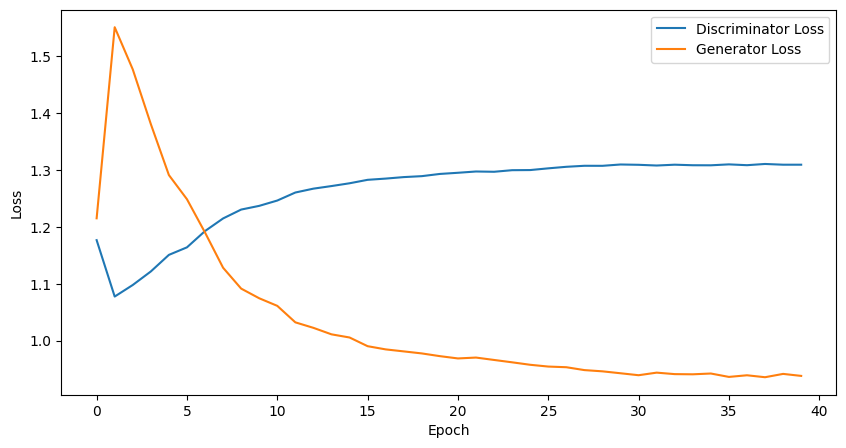

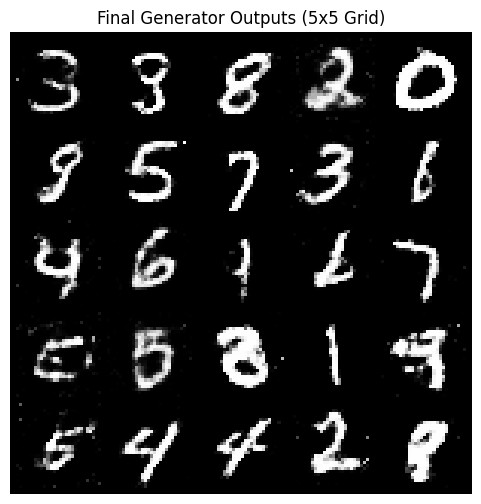

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(D_losses, label="Discriminator Loss")
plt.plot(G_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

z_sample = torch.randn(25, z_dim, device=device)

with torch.no_grad():
    generated_images = G(z_sample).cpu()

grid = torchvision.utils.make_grid(generated_images, nrow=5, normalize=True, value_range=(-1, 1))

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.title("Final Generator Outputs (5x5 Grid)")
plt.axis("off")
plt.show()

**Task 4**

*Part 1*

In [8]:
import sys
from architecture import VAE

import torch.nn.functional as F

FashionMNIST_trainloader, FashionMNIST_testloader = load_dataset('FashionMNIST');
VAE_model = VAE(latent_dim=20).to(device)
VAE_optimizer=torch.optim.Adam(VAE_model.parameters(),lr=1e-3)


def vae_loss(recon_x, x, mu, logvar):
    recon_loss=F.mse_loss(recon_x, x, reduction='sum')/x.size(0)
    kld_loss=-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())/x.size(0)
    total_loss=recon_loss+kld_loss

    return total_loss, recon_loss, kld_loss

epochs=10
train_losses={'total_loss': [], 'recon_loss': [], 'kld_loss': []}
val_losses={'total_loss': [], 'recon_loss': [], 'kld_loss': []}

for epoch in range(epochs):
    VAE_model.train()
    total_loss=0.0
    recon_loss=0.0
    kld_loss=0.0

    for images, _ in FashionMNIST_trainloader:
        images = images.to(device)

        VAE_optimizer.zero_grad()
        recon_x, mu, logvar=VAE_model(images)

        loss, recon, kld=vae_loss(recon_x, images, mu, logvar)
        loss.backward()
        VAE_optimizer.step()

        total_loss+=loss.item()
        recon_loss+=recon.item()
        kld_loss+=kld.item()

    avg_total_loss=total_loss/len(FashionMNIST_trainloader)
    avg_recon_loss=recon_loss/len(FashionMNIST_trainloader)
    avg_kld_loss=kld_loss/len(FashionMNIST_trainloader)

    train_losses['total_loss'].append(avg_total_loss)
    train_losses['recon_loss'].append(avg_recon_loss)
    train_losses['kld_loss'].append(avg_kld_loss)

    VAE_model.eval()
    val_total_loss=0.0
    val_recon_loss=0.0
    val_kld_loss=0.0
    with torch.no_grad():
        for images, _ in FashionMNIST_testloader:
            images = images.to(device)
            recon_x, mu, logvar=VAE_model(images)
            loss, recon, kld=vae_loss(recon_x, images, mu, logvar)

            val_total_loss+=loss.item()
            val_recon_loss+=recon.item()
            val_kld_loss+=kld.item()

    avg_val_total_loss=val_total_loss/len(FashionMNIST_trainloader)
    avg_val_recon_loss=val_recon_loss/len(FashionMNIST_trainloader)
    avg_val_kld_loss=val_kld_loss/len(FashionMNIST_trainloader)

    val_losses['total_loss'].append(avg_val_total_loss)
    val_losses['recon_loss'].append(avg_val_recon_loss)
    val_losses['kld_loss'].append(avg_val_kld_loss)


    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_total_loss:.4f}, Val Loss: {avg_val_total_loss:.4f}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.1MB/s]


Epoch [1/10] Train Loss: 509.8797, Val Loss: 81.1133
Epoch [2/10] Train Loss: 483.3157, Val Loss: 80.2997
Epoch [3/10] Train Loss: 480.5812, Val Loss: 80.0519
Epoch [4/10] Train Loss: 479.3051, Val Loss: 79.9125
Epoch [5/10] Train Loss: 478.4597, Val Loss: 79.7986
Epoch [6/10] Train Loss: 477.9062, Val Loss: 79.7077
Epoch [7/10] Train Loss: 477.5788, Val Loss: 79.6573
Epoch [8/10] Train Loss: 477.2428, Val Loss: 79.6367
Epoch [9/10] Train Loss: 476.9864, Val Loss: 79.6081
Epoch [10/10] Train Loss: 476.8023, Val Loss: 79.5779


*Part 2*

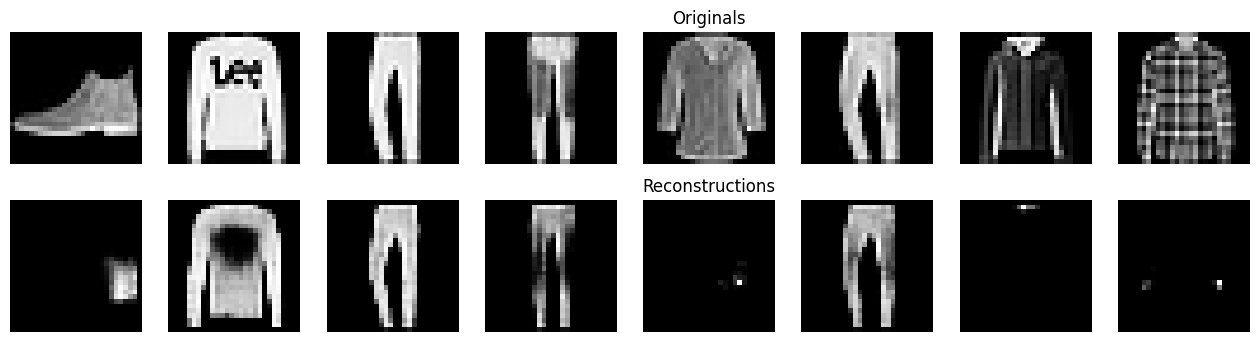

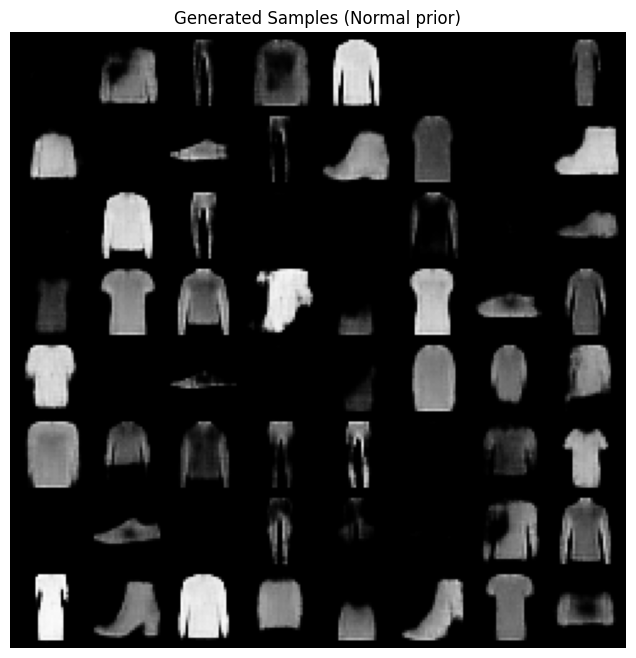

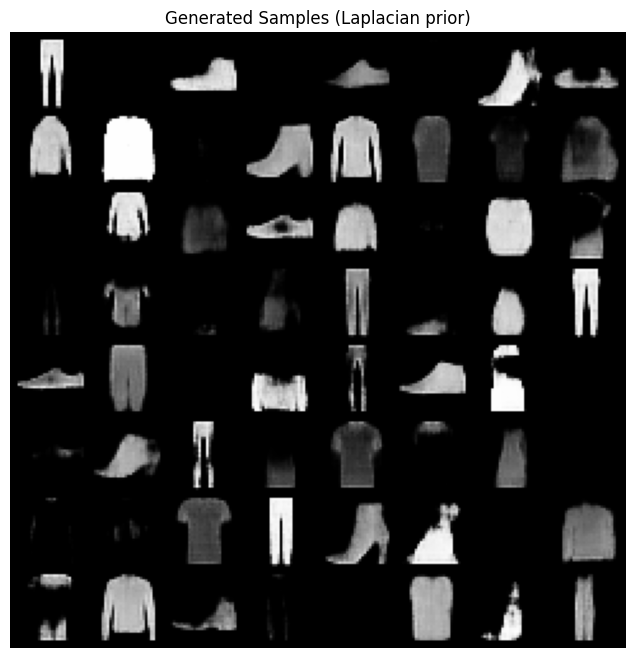

In [9]:
images, _ = next(iter(FashionMNIST_testloader))
images = images.to(device)

with torch.no_grad():
    recon_images, _, _ = VAE_model(images)

images = images.cpu()
recon_images = recon_images.cpu()

n = 8
plt.figure(figsize=(16,4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == n//2:
        plt.title("Originals", fontsize=12)

    plt.subplot(2, n, i+1+n)
    plt.imshow(recon_images[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == n//2:
        plt.title("Reconstructions", fontsize=12)
plt.show()


with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    samples = VAE_model.decode(z).cpu()

grid = torchvision.utils.make_grid(samples, nrow=8, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Generated Samples (Normal prior)")
plt.show()


def sample_laplace(shape, device, scale=1.0):
    u = torch.rand(shape, device=device) - 0.5
    return -scale * torch.sign(u) * torch.log1p(-2*torch.abs(u))

with torch.no_grad():
    z_laplace = sample_laplace((64, 20), device=device)
    samples_laplace = VAE_model.decode(z_laplace).cpu()

grid_laplace = torchvision.utils.make_grid(samples_laplace, nrow=8, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid_laplace.permute(1,2,0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Generated Samples (Laplacian prior)")
plt.show()


*Part 3*

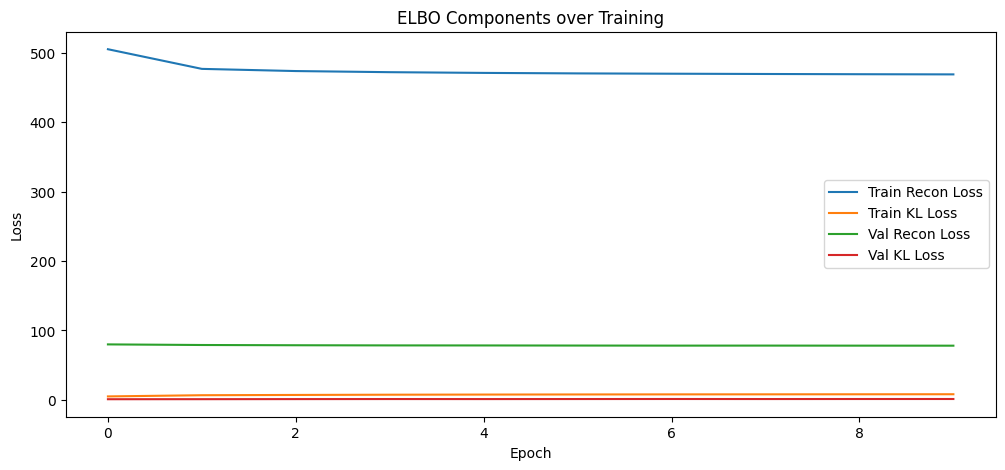

Final average KL divergence: 1.4223
KL divergence is non-zero, posterior collapse less likely.
Mean of |mu| across batch: 0.2594607174396515
Mean of logvar across batch: -0.8266181349754333


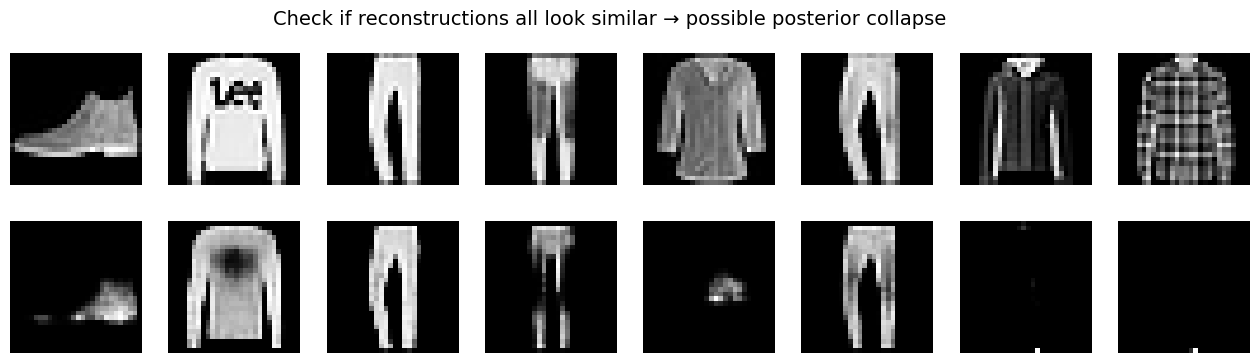

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(train_losses['recon_loss'], label="Train Recon Loss")
plt.plot(train_losses['kld_loss'], label="Train KL Loss")
plt.plot(val_losses['recon_loss'], label="Val Recon Loss")
plt.plot(val_losses['kld_loss'], label="Val KL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("ELBO Components over Training")
plt.show()

avg_final_kl = val_losses['kld_loss'][-1]
print(f"Final average KL divergence: {avg_final_kl:.4f}")

if avg_final_kl < 1e-3:
    print(" Posterior collapse is likely. Encoder is ignoring inputs.")
else:
    print("KL divergence is non-zero, posterior collapse less likely.")


images, _ = next(iter(FashionMNIST_testloader))
images = images.to(device)

with torch.no_grad():
    _, mu, logvar = VAE_model(images)

print("Mean of |mu| across batch:", mu.abs().mean().item())
print("Mean of logvar across batch:", logvar.mean().item())

with torch.no_grad():
    recon_images, _, _ = VAE_model(images)

n = 8
plt.figure(figsize=(16,4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

    plt.subplot(2, n, i+1+n)
    plt.imshow(recon_images[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("Check if reconstructions all look similar → possible posterior collapse", fontsize=14)
plt.show()

*Part 4*

In [ ]:
def vae_loss_better(recon_x, x, mu, logvar, kl_weight):
    recon_loss=F.mse_loss(recon_x, x, reduction='sum')/x.size(0)
    kld_loss=-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())/x.size(0)
    total_loss=recon_loss+kl_weight*kld_loss

    return total_loss, recon_loss, kld_loss

epochs=20
kl_start = 0.0
kl_end = 1.0
anneal_epochs=10

train_losses={'total_loss': [], 'recon_loss': [], 'kld_loss': []}
val_losses={'total_loss': [], 'recon_loss': [], 'kld_loss': []}

for epoch in range(epochs):
    kl_weight = min(kl_end, kl_start + (epoch / anneal_epochs) * (kl_end - kl_start))

    VAE_model.train()
    total_loss=0.0
    recon_loss=0.0
    kld_loss=0.0

    for images, _ in FashionMNIST_trainloader:
        images = images.to(device)

        VAE_optimizer.zero_grad()
        recon_x, mu, logvar=VAE_model(images)

        loss, recon, kld=vae_loss_better(recon_x, images, mu, logvar, kl_weight)
        loss.backward()
        VAE_optimizer.step()

        total_loss+=loss.item()
        recon_loss+=recon.item()
        kld_loss+=kld.item()

    avg_total_loss=total_loss/len(FashionMNIST_trainloader)
    avg_recon_loss=recon_loss/len(FashionMNIST_trainloader)
    avg_kld_loss=kld_loss/len(FashionMNIST_trainloader)

    train_losses['total_loss'].append(avg_total_loss)
    train_losses['recon_loss'].append(avg_recon_loss)
    train_losses['kld_loss'].append(avg_kld_loss)

    VAE_model.eval()
    val_total_loss=0.0
    val_recon_loss=0.0
    val_kld_loss=0.0
    with torch.no_grad():
        for images, _ in FashionMNIST_testloader:
            images = images.to(device)
            recon_x, mu, logvar=VAE_model(images)
            loss, recon, kld=vae_loss(recon_x, images, mu, logvar)

            val_total_loss+=loss.item()
            val_recon_loss+=recon.item()
            val_kld_loss+=kld.item()

    avg_val_total_loss=val_total_loss/len(FashionMNIST_trainloader)
    avg_val_recon_loss=val_recon_loss/len(FashionMNIST_trainloader)
    avg_val_kld_loss=val_kld_loss/len(FashionMNIST_trainloader)

    val_losses['total_loss'].append(avg_val_total_loss)
    val_losses['recon_loss'].append(avg_val_recon_loss)
    val_losses['kld_loss'].append(avg_val_kld_loss)


    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_total_loss:.4f}, Val Loss: {avg_val_total_loss:.4f}")

Epoch [1/20] Train Loss: 463.3890, Val Loss: 86.0418
Epoch [2/20] Train Loss: 465.0972, Val Loss: 80.4459
Epoch [3/20] Train Loss: 466.5431, Val Loss: 79.9350
Epoch [4/20] Train Loss: 467.9332, Val Loss: 79.7756
Epoch [5/20] Train Loss: 469.1752, Val Loss: 79.6447
Epoch [6/20] Train Loss: 470.3742, Val Loss: 79.5266
Epoch [7/20] Train Loss: 471.5040, Val Loss: 79.4634
Epoch [8/20] Train Loss: 472.5326, Val Loss: 79.4165
Epoch [9/20] Train Loss: 473.5532, Val Loss: 79.3937
Epoch [10/20] Train Loss: 474.4622, Val Loss: 79.3964
Epoch [11/20] Train Loss: 475.4104, Val Loss: 79.3937
Epoch [12/20] Train Loss: 475.3772, Val Loss: 79.3479
Epoch [13/20] Train Loss: 475.2994, Val Loss: 79.3811
Epoch [14/20] Train Loss: 475.2771, Val Loss: 79.3643
Epoch [15/20] Train Loss: 475.2731, Val Loss: 79.3705
Epoch [16/20] Train Loss: 475.2089, Val Loss: 79.3385
Epoch [17/20] Train Loss: 475.1678, Val Loss: 79.3365
Epoch [18/20] Train Loss: 475.1672, Val Loss: 79.3480
Epoch [19/20] Train Loss: 475.1286, V

**Task 5**

Part 1

In [1]:
# !pip install git+https://github.com/openai/CLIP.git --upgrade --force-reinstall

import clip
from PIL import Image
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

STL_trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=clip_preprocess)
STL_trainloader = torch.utils.data.DataLoader(STL_trainset, batch_size=64, shuffle=True, num_workers=2)

STL_testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=clip_preprocess)
STL_testloader = torch.utils.data.DataLoader(STL_testset, batch_size=64, shuffle=False, num_workers=2)

class_names = ["airplane", "bird", "car", "cat", "deer","dog", "horse", "monkey", "ship", "truck"]

plain_prompts = [name for name in class_names]
photo_prompts = [f"a photo of a {name}" for name in class_names]
descriptive_prompts = [f"a detailed and high quality photo of a {name}" for name in class_names]


def encode_prompts(prompts, model):
    with torch.no_grad():
        text_tokens = clip.tokenize(prompts).to(device)
        text_features = model.encode_text(text_tokens).to(device)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features


def evaluate_accuracy(dataloader, prompts):
    text_features = encode_prompts(prompts, clip_model)
    total, correct = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            image_features = clip_model.encode_image(images).to(device)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarities = image_features @ text_features.T
            predictions = similarities.argmax(dim=-1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total


plain_acc = evaluate_accuracy(STL_testloader, plain_prompts)
photo_acc = evaluate_accuracy(STL_testloader, photo_prompts)
desc_acc = evaluate_accuracy(STL_testloader, descriptive_prompts)

print(f"Plain labels accuracy: {plain_acc:.4f}")
print(f"'a photo of ...' accuracy: {photo_acc:.4f}")
print(f"Descriptive accuracy: {desc_acc:.4f}")

Plain labels accuracy: 0.9626
'a photo of ...' accuracy: 0.9736
Descriptive accuracy: 0.9673


*Part 2*

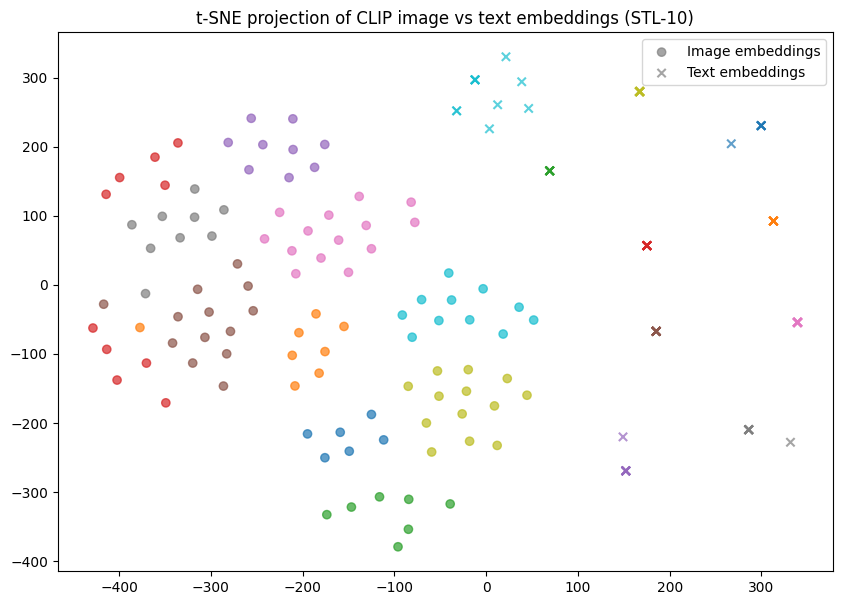

In [4]:
subset_size = 100
indices = torch.randperm(len(STL_testset))[:subset_size]
subset = torch.utils.data.Subset(STL_testset, indices)
subset_loader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=False)

image_embeddings, text_embeddings, labels_list = [], [], []

with torch.no_grad():
    for images, labels in subset_loader:
        images, labels = images.to(device), labels.to(device)

        img_feats = clip_model.encode_image(images)
        img_feats /= img_feats.norm(dim=-1, keepdim=True)
        image_embeddings.append(img_feats.cpu())

        prompts = [f"a photo of a {class_names[l]}" for l in labels]
        tokens = clip.tokenize(prompts).to(device)
        txt_feats = clip_model.encode_text(tokens)
        txt_feats /= txt_feats.norm(dim=-1, keepdim=True)
        text_embeddings.append(txt_feats.cpu())

        labels_list.append(labels.cpu())

image_embeddings = torch.cat(image_embeddings, dim=0).numpy()
text_embeddings = torch.cat(text_embeddings, dim=0).numpy()
labels_list = torch.cat(labels_list, dim=0).numpy()

all_embeddings = np.concatenate([image_embeddings, text_embeddings], axis=0)
all_2d = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(all_embeddings)

image_2d = all_2d[:subset_size]
text_2d = all_2d[subset_size:]

plt.figure(figsize=(10, 7))

plt.scatter(image_2d[:,0], image_2d[:,1], c=labels_list, cmap="tab10", marker="o", alpha=0.7, label="Image embeddings")

plt.scatter(text_2d[:,0], text_2d[:,1], c=labels_list, cmap="tab10", marker="x", alpha=0.7, label="Text embeddings")

plt.legend()
plt.title("t-SNE projection of CLIP image vs text embeddings (STL-10)")
plt.show()


*Part 3*

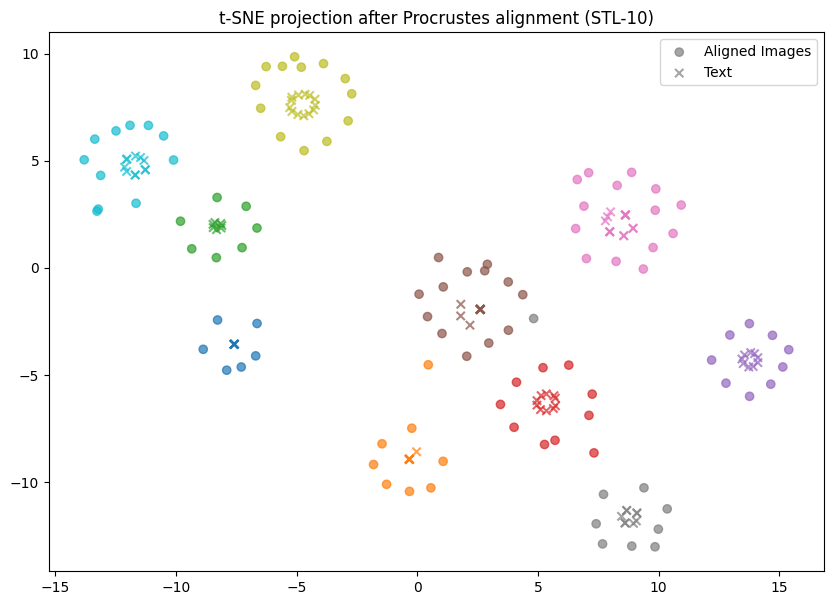


--- After Procrustes Alignment ---
Plain labels accuracy: 0.9411
'a photo of ...' accuracy: 0.9637
Descriptive accuracy: 0.9616


In [ ]:
from scipy.linalg import orthogonal_procrustes

X = image_embeddings
Y = text_embeddings

R, _ = orthogonal_procrustes(X, Y)

X_aligned = X @ R

all_embeddings_aligned = np.concatenate([X_aligned, Y], axis=0)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
all_2d_aligned = tsne.fit_transform(all_embeddings_aligned)

image_2d_aligned = all_2d_aligned[:len(X)]
text_2d_aligned = all_2d_aligned[len(X):]

plt.figure(figsize=(10, 7))
plt.scatter(image_2d_aligned[:,0], image_2d_aligned[:,1], c=labels_list, cmap="tab10", marker="o", alpha=0.7, label="Aligned Images")
plt.scatter(text_2d_aligned[:,0], text_2d_aligned[:,1], c=labels_list, cmap="tab10", marker="x", alpha=0.7, label="Text")
plt.legend()
plt.title("t-SNE projection after Procrustes alignment (STL-10)")
plt.show()

def evaluate_with_alignment(dataloader, prompts, R):
    text_features = encode_prompts(prompts, clip_model).cpu().numpy()
    total, correct = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            image_features = image_features.cpu().numpy() @ R
            text_features_norm = text_features / np.linalg.norm(text_features, axis=-1, keepdims=True)

            similarities = image_features @ text_features_norm.T
            predictions = similarities.argmax(axis=-1)

            correct += (predictions == labels.cpu().numpy()).sum().item()
            total += labels.size(0)

    return correct / total

plain_acc_aligned = evaluate_with_alignment(STL_testloader, plain_prompts, R)
photo_acc_aligned = evaluate_with_alignment(STL_testloader, photo_prompts, R)
desc_acc_aligned = evaluate_with_alignment(STL_testloader, descriptive_prompts, R)

print("\n--- After Procrustes Alignment ---")
print(f"Plain labels accuracy: {plain_acc_aligned:.4f}")
print(f"'a photo of ...' accuracy: {photo_acc_aligned:.4f}")
print(f"Descriptive accuracy: {desc_acc_aligned:.4f}")

